In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from ax.utils.notebook.plotting import render
from captum.attr import IntegratedGradients

In [5]:
# !conda install pytorch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 pytorch-cuda=12.1 -c pytorch -c nvidia

In [6]:
# !pip install ax-platform

In [7]:
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())

2.2.1
CUDA Available: True


# # 1. Observe the data

In [8]:
# one_train_pssm = pd.read_csv('deep-learning-for-msc-202324/train/1A0A_3_A_train.csv')
# one_train_pssm

In [9]:
# seqs_test = pd.read_csv('deep-learning-for-msc-202324/seqs_test.csv')
# seqs_test

In [10]:
# seqs_train = pd.read_csv('deep-learning-for-msc-202324/seqs_train.csv')
# seqs_train

In [11]:
# labels_train = pd.read_csv('deep-learning-for-msc-202324/labels_train.csv')
# labels_train

# 2. Define the dataset and data loaders

In [12]:
class ProteinDataset(Dataset):
    """
    It is used to load and preprocess the protein sequence and label data. It also reads the PSSM data from the provided files.
    
    :param seq_file_path: The file path to the sequence data
    :type seq_file_path: str
    :param pssm_files_path: The directory path to the PSSM files
    :type pssm_files_path: str
    :param label_file_path: The file path to the label data
    :type label_file_path: str
    :param indices: The indices of the data to select
    :type indices: list
    
    :return: The protein dataset
    :rtype: Dataset
    """

    def __init__(self, seq_file_path, pssm_files_path, label_file_path=None, indices=None):
        # Define the amino acid and structure mappings
        self.amino_acid_to_ix = {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10,
                                 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19,
                                 'Y': 20}
        self.struct_to_ix = {'H': 0, 'E': 1, 'C': 2}


        

        # Read the sequence data, and select a subset of the data if indices are provided(train set and val set)
        self.seq_data = pd.read_csv(seq_file_path)
        self.real_lan = [len(seq) for seq in self.seq_data['SEQUENCE']]
        if indices is not None:
            self.seq_data = self.seq_data.iloc[indices].reset_index(drop=True)

        # Read the PSSM files path
        self.pssm_files_path = pssm_files_path

        # Read the label data, and select a subset of the data if indices are provided
        if label_file_path:
            self.label_data = pd.read_csv(label_file_path)
            if indices is not None:
                self.label_data = self.label_data.iloc[indices].reset_index(drop=True)
        else:
            self.label_data = None

    def __len__(self):
        return len(self.seq_data)

    def __getitem__(self, idx):
        """
        It is used to get the sequence, label, and PSSM data for a given index.
        
        :param idx: The index of the data to retrieve 
        :type idx: int
        :return: The sequence, label, and PSSM data
        :rtype: dict
        """
        pdb_id = self.seq_data.iloc[idx, 0]
        sequence = self.seq_data.iloc[idx, 1]
        sequence_encoded = [self.amino_acid_to_ix[aa] for aa in sequence]

        if self.label_data is not None:
            label_sequence = self.label_data[self.label_data['PDB_ID'] == pdb_id].iloc[0, 1]
            label_encoded = [self.struct_to_ix[label] for label in label_sequence]
        else:
            label_encoded = [-1] * len(sequence)  # 使用 -1 作为未知标签的占位符

        pssm_file_path = os.path.join(self.pssm_files_path, f"{pdb_id}_test.csv" if self.label_data is None else f"{pdb_id}_train.csv")
        pssm_data = pd.read_csv(pssm_file_path).iloc[:, 2:].to_numpy()

        return {
            'pdb_id': pdb_id,
            'sequence': torch.tensor(sequence_encoded, dtype=torch.long),
            'labels': torch.tensor(label_encoded, dtype=torch.long),
            'pssm': torch.tensor(pssm_data, dtype=torch.float),
            'real_len': self.real_lan[idx]
        }

In [13]:
def protein_collate_fn(batch):
    """
    It is used to process and prepare batched data during data loading. The DataLoader object can accept a function through the collate_fn parameter to customize how to combine multiple samples into a batch. This is particularly useful when dealing with sequence data, as the lengths of sequence data are often not consistent and need to be padded or otherwise processed to ensure that all data in a batch have consistent dimensions.
    :param batch: The batch of data to process
    :type batch: int
    :return: A dictionary containing the processed batched data
    :rtype: dict
    """
    sequences, labels, pssms, pdb_ids, real_lens = zip(*[(sample['sequence'], sample['labels'], sample['pssm'], sample['pdb_id'], sample['real_len']) for sample in batch])


    # Pad sequence and label data
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_padded = pad_sequence(labels, batch_first=True)

    # Pad PSSM data
    pssms_padded = pad_sequence(pssms, batch_first=True, padding_value=-1)  # Use -1 to pad the PSSM data

    return {'sequence': sequences_padded,
            'labels': labels_padded,
            'pssm': pssms_padded,
            'pdb_id': pdb_ids,
            'real_len': torch.tensor(real_lens)}

In [14]:
def get_data_loaders(batch_size):
    """
    It is used to create training and validation data loaders for the protein secondary structure prediction model. The function loads the sequence data, label data, and PSSM data, and then creates a training and validation split of the data. The function then creates data loaders for the training and validation data.
    :param batch_size: batch size for the data loaders
    :type batch_size: int
    :return: a tuple containing the training and validation data loaders
    :rtype: tuple
    """
    seqs_file_path = 'kaggle/input/deep-learning-for-msc-202324/seqs_train.csv'
    label_file_path = 'kaggle/input/deep-learning-for-msc-202324/labels_train.csv'
    pssm_files_path = 'kaggle/input/deep-learning-for-msc-202324/train/'

    # load the sequence data and generate a list of PDB IDs
    seqs_data = pd.read_csv(seqs_file_path)
    # pdb_ids = seqs_data['PDB_ID'].tolist()
    indices = range(len(seqs_data))

    # split the PDB_ID list into training and validation sets
    pdb_ids_train, pdb_ids_val = train_test_split(indices, test_size=0.2, random_state=10)

    # create training and validation data loaders
    dataset_train = ProteinDataset(seqs_file_path, pssm_files_path, label_file_path, pdb_ids_train)
    dataset_val = ProteinDataset(seqs_file_path, pssm_files_path, label_file_path, pdb_ids_val)

    # create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=protein_collate_fn,
                                  pin_memory=True)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=protein_collate_fn,
                                pin_memory=True)

    return dataloader_train, dataloader_val

# 3. Design the model(Fully Convolutional Networks, FCN)

In [15]:
class ProteinSecondaryStructureFCNwithEmbedding(nn.Module):
    """
    It is used to define a fully convolutional neural network (FCN) model for protein secondary structure prediction. The model uses an embedding layer to embed the amino acid sequence data, and then concatenates the embedded sequence data with the PSSM data before applying convolutional layers to learn features from the data. The model outputs a sequence of predictions for the secondary structure of the protein.
    """

    def __init__(self, embedding_dim=10, dropout_rate=0.5):
        num_amino_acids = 20
        num_pssm_features = 20
        num_classes = 3
        super(ProteinSecondaryStructureFCNwithEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=num_amino_acids + 1,
                                      embedding_dim=embedding_dim)

        # convolutional layers
        self.layer1 = nn.Sequential(nn.Conv1d(embedding_dim + num_pssm_features, 64, kernel_size=5, padding=2),
                                    nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(dropout_rate))
        self.layer2 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=5, padding=2), nn.ReLU(), nn.BatchNorm1d(128),
                                    nn.Dropout(dropout_rate))
        self.layer3 = nn.Sequential(nn.Conv1d(128, 256, kernel_size=5, padding=2), nn.ReLU(), nn.BatchNorm1d(256),
                                    nn.Dropout(dropout_rate))
        self.layer4 = nn.Sequential(nn.Conv1d(256, 512, kernel_size=5, padding=2), nn.ReLU(), nn.BatchNorm1d(512),
                                    nn.Dropout(dropout_rate))
        self.output_layer = nn.Conv1d(512, num_classes, kernel_size=1)

    def forward(self, sequence, pssm):
        # sequence: [batch_size, seq_len]
        # pssm: [batch_size, seq_len, num_pssm_features]

        # embed the sequence
        embedded_sequence = self.embedding(sequence)  # [batch_size, seq_len, embedding_dim]

        # adjust the dimensions of the embedded sequence to be concatenated with the PSSM
        embedded_sequence = embedded_sequence.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]

        # concatenate the embedded sequence and PSSM data
        combined_input = torch.cat((embedded_sequence, pssm.permute(0, 2, 1)),
                                   dim=1)  # [batch_size, embedding_dim+num_pssm_features, seq_len]

        # apply the network layers
        out = self.layer1(combined_input)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.output_layer(out)

        return out.permute(0, 2, 1)  # [batch_size, seq_len, num_classes]

In [16]:
def train_model(batch_size=4, num_epochs=10, embedding_dim=10, dropout_rate=0.5, lr=0.0001):
    """
    It is used to train the protein secondary structure prediction model. The function creates the data loaders, initializes the model, loss function, and optimizer, and then trains the model for the specified number of epochs. The function returns the trained model and the training and validation performance metrics.
    :param batch_size: batch size for the data loaders
    :type batch_size: int
    :param num_epochs: the number of epochs to train the model
    :type num_epochs: int
    :param embedding_dim: the dimension of the embedding layer
    :type embedding_dim: int
    :param dropout_rate: the dropout rate for the model
    :type dropout_rate: float
    :param lr: the learning rate for the optimizer
    :type lr: float
    :return: a dictionary containing the trained model and the training and validation performance metrics
    :rtype: dict
    """
    train_loader, val_loader = get_data_loaders(batch_size)
    model = ProteinSecondaryStructureFCNwithEmbedding(embedding_dim=embedding_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Cross entropy loss function for classification problems
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # initialize lists to store performance metrics
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        train_losses, train_true, train_pred = [], [], []

        # Training loop
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
            sequences = batch['sequence'].to(device)
            labels = batch['labels'].to(device)
            pssms = batch['pssm'].to(device)

            # Forward pass
            outputs = model(sequences, pssms)
            loss = criterion(outputs.reshape(-1, 3), labels.reshape(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the training loss
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 2)
            train_true.extend(labels.view(-1).cpu().numpy())
            train_pred.extend(predicted.view(-1).cpu().numpy())

        # Calculate the training performance metrics
        metrics['train_loss'].append(np.mean(train_losses))
        metrics['train_accuracy'].append(accuracy_score(train_true, train_pred))
        metrics['train_precision'].append(precision_score(train_true, train_pred, average='macro', zero_division=0))
        metrics['train_recall'].append(recall_score(train_true, train_pred, average='macro', zero_division=0))
        metrics['train_f1'].append(f1_score(train_true, train_pred, average='macro', zero_division=0))

        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}, Train Precision: {metrics["train_precision"][-1]:.4f}, Train Recall: {metrics["train_recall"][-1]:.4f}, Train F1: {metrics["train_f1"][-1]:.4f}')
        
        torch.cuda.empty_cache()  # clean up CUDA memory

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_losses, val_true, val_pred = [], [], []

        with torch.no_grad():
            for batch in val_loader:
                sequences = batch['sequence'].to(device)
                labels = batch['labels'].to(device)
                pssms = batch['pssm'].to(device)

                # Forward pass
                outputs = model(sequences, pssms)
                loss = criterion(outputs.reshape(-1, 3), labels.reshape(-1))

                # Track the validation loss
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 2)
                val_true.extend(labels.view(-1).cpu().numpy())
                val_pred.extend(predicted.view(-1).cpu().numpy())

        # Calculate the validation performance metrics
        metrics['val_loss'].append(np.mean(val_losses))
        metrics['val_accuracy'].append(accuracy_score(val_true, val_pred))
        metrics['val_precision'].append(precision_score(val_true, val_pred, average='macro', zero_division=0))
        metrics['val_recall'].append(recall_score(val_true, val_pred, average='macro', zero_division=0))
        metrics['val_f1'].append(f1_score(val_true, val_pred, average='macro', zero_division=0))

        print(
            f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {metrics["val_loss"][-1]:.4f}, Validation Accuracy: {metrics["val_accuracy"][-1]:.4f}, Validation Precision: {metrics["val_precision"][-1]:.4f}, Validation Recall: {metrics["val_recall"][-1]:.4f}, Validation F1: {metrics["val_f1"][-1]:.4f}')
        
        # torch.cuda.empty_cache()  # clean up CUDA memory
        
    return {'model': model, 'metrics': metrics}

# 4. Train the model and evaluate the performance

In [17]:
torch.cuda.is_available()

True

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

In [20]:
# # Ensure you have defined and instantiated your DataLoader here
# train_rsults = train_model(batch_size=32, num_epochs=10, embedding_dim=15, dropout_rate=0.234673, lr=0.000143)

In [21]:
# display(train_rsults['model'])

In [22]:
# # Save the trained model
# torch.save(train_rsults['model'].state_dict(), 'prediction_model_default_para.pth')

In [49]:
def plot_loss_accuracy_history(metrics):
    """
    绘制训练和验证损失及准确率的趋势图。
    """
    train_loss_history = metrics['train_loss']
    val_loss_history = metrics['val_loss']
    train_accuracy_history = metrics['train_accuracy']
    val_accuracy_history = metrics['val_accuracy']
    
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_history, label='Train Loss')
    plt.plot(epochs, val_loss_history, label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_history, label='Train Accuracy')
    plt.plot(epochs, val_accuracy_history, label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('loss_accuracy_history.png')
    plt.show()

In [24]:
# display(train_rsults['metrics'])

In [25]:
# plot_loss_accuracy_history(train_rsults['metrics'])

# 5. Hyperparameter optimization with Ax

In [26]:
def train_evaluate(parameterization):
    """
    It is used to train and evaluate the protein secondary structure prediction model with the given hyperparameters.
    :param parameterization: A dictionary containing the hyperparameters to use for training and evaluation
    :type parameterization: dict
    :return: A dictionary containing the validation performance metrics
    :rtype: dict
    """
    # extract the hyperparameters from the parameterization
    learning_rate = parameterization["lr"]
    dropout_rate = parameterization["dropout_rate"]
    batch_size = parameterization["batch_size"]
    embedding_dim = parameterization["embedding_dim"]

    # use the extracted hyperparameters to train and evaluate the model
    metrics = \
        train_model(batch_size=batch_size, embedding_dim=embedding_dim, dropout_rate=dropout_rate, lr=learning_rate)[
            'metrics']

    val_loss = metrics['val_loss'][-1]
    val_accuracy = metrics['val_accuracy'][-1]
    val_precision = metrics['val_precision'][-1]
    val_recall = metrics['val_recall'][-1]
    val_f1 = metrics['val_f1'][-1]

    return {"val_loss": (val_loss, 0.0), "val_accuracy": (val_accuracy, 0.0), "val_precision": (val_precision, 0.0),
            "val_recall": (val_recall, 0.0), "val_f1": (val_f1, 0.0)}

In [27]:
# ax_client = AxClient()
# ax_client.create_experiment(
#     name="protein_structure_prediction_experiment",
#     parameters=[
#         {"name": "lr", "type": "range", "bounds": [5e-4, 3e-3], "log_scale": True},
#         {"name": "dropout_rate", "type": "range", "bounds": [0.15, 0.2]},
#         {"name": "batch_size", "type": "choice", "values": [32, 64]},
#         {"name": "embedding_dim", "type": "choice", "values": [4, 5, 6, 7]},
#     ],
#     objectives={"val_loss": ObjectiveProperties(minimize=True)},
#     tracking_metric_names=["val_accuracy", "val_precision", "val_recall", "val_f1"],
# )


In [28]:
# times_ax = 10
# for i in range(times_ax):
#     print(f"Running optimization iteration {i+1}/{times_ax}...")
#     parameters, trial_index = ax_client.get_next_trial()
#     ax_client.complete_trial(trial_index=trial_index, raw_data=train_evaluate(parameters)) 

In [29]:
# best_parameters_with_eval_value = ax_client.get_best_parameters()
# display(best_parameters_with_eval_value)

In [30]:
# best_parameters = best_parameters_with_eval_value[0]

Show the best parameters after ax

In [31]:
# best_parameters

After 80+ times of optimization, the best parameters are:
{'lr': 0.0010683100009095904,
 'dropout_rate': 0.1748906408059711,
 'batch_size': 64,
 'embedding_dim': 7}

In [32]:
# results_df = ax_client.get_trials_data_frame()
# results_df

In [33]:
# results_df.to_csv('10_trials_2_results.csv', index=False)

Plotting to aid in parameterisation

In [34]:
# render(ax_client.get_contour_plot(param_x="lr", param_y="dropout_rate", metric_name="val_accuracy"))

In [35]:
# render(ax_client.get_contour_plot(param_x="dropout_rate", param_y="embedding_dim", metric_name="val_accuracy"))

In [36]:
# render(ax_client.get_contour_plot(param_x="lr", param_y="embedding_dim", metric_name="val_accuracy"))

In [37]:
# render(ax_client.get_optimization_trace())

In [38]:
# from ax.plot.slice import plot_slice
# render(plot_slice(
#     model=ax_client.generation_strategy.model,
#     param_name='lr',
#     metric_name='val_accuracy'
# ))

In [39]:
# render(plot_slice(
#     model=ax_client.generation_strategy.model,
#     param_name='embedding_dim',
#     metric_name='val_accuracy'
# ))

In [40]:
# render(plot_slice(
#     model=ax_client.generation_strategy.model,
#     param_name='dropout_rate',
#     metric_name='val_accuracy'
# ))

# 6. Train the model with the best hyperparameters and make predictions of the test set

In [41]:
best_parameters = {'lr': 0.0015518165052243,
                   'dropout_rate': 0.1858316733276795,
                   'batch_size': 64,
                   'embedding_dim': 7}

In [51]:
def test_train(best_parameters):

    batch_size = best_parameters['batch_size']
    embedding_dim = best_parameters['embedding_dim']
    dropout_rate = best_parameters['dropout_rate']
    lr = best_parameters['lr']
    num_epochs = 150

    best_results = train_model(batch_size=batch_size, num_epochs=num_epochs, embedding_dim=embedding_dim, dropout_rate=dropout_rate, lr=lr)
    
    # save the trained model
    filename = f"{batch_size}_{num_epochs}_{embedding_dim}_{dropout_rate}_{lr}"
    torch.save(best_results['model'].state_dict(), f'{filename}.pth')
    
    return best_results, filename    

In [52]:
best_results, filename = test_train(best_parameters)

Training Epoch 1/150: 100%|██████████| 90/90 [00:22<00:00,  4.01it/s]


Epoch [1/150], Train Loss: 0.5397, Train Accuracy: 0.8756, Train Precision: 0.6231, Train Recall: 0.6663, Train F1: 0.6419
Epoch [1/150], Validation Loss: 0.3293, Validation Accuracy: 0.9067, Validation Precision: 0.7582, Validation Recall: 0.7047, Validation F1: 0.7286


Training Epoch 2/150: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s]


Epoch [2/150], Train Loss: 0.2652, Train Accuracy: 0.9165, Train Precision: 0.7522, Train Recall: 0.7375, Train F1: 0.7426
Epoch [2/150], Validation Loss: 0.2070, Validation Accuracy: 0.9240, Validation Precision: 0.7915, Validation Recall: 0.7767, Validation F1: 0.7833


Training Epoch 3/150: 100%|██████████| 90/90 [00:18<00:00,  4.90it/s]


Epoch [3/150], Train Loss: 0.1923, Train Accuracy: 0.9300, Train Precision: 0.7890, Train Recall: 0.7796, Train F1: 0.7827
Epoch [3/150], Validation Loss: 0.1815, Validation Accuracy: 0.9294, Validation Precision: 0.8092, Validation Recall: 0.7994, Validation F1: 0.7982


Training Epoch 4/150: 100%|██████████| 90/90 [00:21<00:00,  4.19it/s]


Epoch [4/150], Train Loss: 0.1803, Train Accuracy: 0.9322, Train Precision: 0.7973, Train Recall: 0.7863, Train F1: 0.7901
Epoch [4/150], Validation Loss: 0.1760, Validation Accuracy: 0.9311, Validation Precision: 0.8269, Validation Recall: 0.7779, Validation F1: 0.7982


Training Epoch 5/150: 100%|██████████| 90/90 [00:41<00:00,  2.18it/s]


Epoch [5/150], Train Loss: 0.1725, Train Accuracy: 0.9341, Train Precision: 0.8069, Train Recall: 0.7949, Train F1: 0.7994
Epoch [5/150], Validation Loss: 0.1682, Validation Accuracy: 0.9343, Validation Precision: 0.8095, Validation Recall: 0.8197, Validation F1: 0.8142


Training Epoch 6/150: 100%|██████████| 90/90 [00:31<00:00,  2.86it/s]


Epoch [6/150], Train Loss: 0.1625, Train Accuracy: 0.9373, Train Precision: 0.8139, Train Recall: 0.8022, Train F1: 0.8065
Epoch [6/150], Validation Loss: 0.1629, Validation Accuracy: 0.9359, Validation Precision: 0.8150, Validation Recall: 0.8230, Validation F1: 0.8184


Training Epoch 7/150: 100%|██████████| 90/90 [00:20<00:00,  4.35it/s]


Epoch [7/150], Train Loss: 0.1633, Train Accuracy: 0.9380, Train Precision: 0.8151, Train Recall: 0.8009, Train F1: 0.8064
Epoch [7/150], Validation Loss: 0.1623, Validation Accuracy: 0.9364, Validation Precision: 0.8197, Validation Recall: 0.8178, Validation F1: 0.8186


Training Epoch 8/150: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch [8/150], Train Loss: 0.1559, Train Accuracy: 0.9404, Train Precision: 0.8194, Train Recall: 0.8072, Train F1: 0.8119
Epoch [8/150], Validation Loss: 0.1591, Validation Accuracy: 0.9372, Validation Precision: 0.8346, Validation Recall: 0.8041, Validation F1: 0.8161


Training Epoch 9/150: 100%|██████████| 90/90 [00:18<00:00,  4.84it/s]


Epoch [9/150], Train Loss: 0.1542, Train Accuracy: 0.9408, Train Precision: 0.8212, Train Recall: 0.8080, Train F1: 0.8132
Epoch [9/150], Validation Loss: 0.1649, Validation Accuracy: 0.9347, Validation Precision: 0.8464, Validation Recall: 0.7789, Validation F1: 0.8070


Training Epoch 10/150: 100%|██████████| 90/90 [00:20<00:00,  4.44it/s]


Epoch [10/150], Train Loss: 0.1513, Train Accuracy: 0.9417, Train Precision: 0.8243, Train Recall: 0.8101, Train F1: 0.8158
Epoch [10/150], Validation Loss: 0.1564, Validation Accuracy: 0.9380, Validation Precision: 0.8372, Validation Recall: 0.8109, Validation F1: 0.8179


Training Epoch 11/150: 100%|██████████| 90/90 [00:18<00:00,  4.74it/s]


Epoch [11/150], Train Loss: 0.1499, Train Accuracy: 0.9421, Train Precision: 0.8262, Train Recall: 0.8121, Train F1: 0.8177
Epoch [11/150], Validation Loss: 0.1542, Validation Accuracy: 0.9392, Validation Precision: 0.8402, Validation Recall: 0.8083, Validation F1: 0.8216


Training Epoch 12/150: 100%|██████████| 90/90 [00:21<00:00,  4.26it/s]


Epoch [12/150], Train Loss: 0.1486, Train Accuracy: 0.9432, Train Precision: 0.8274, Train Recall: 0.8134, Train F1: 0.8190
Epoch [12/150], Validation Loss: 0.1536, Validation Accuracy: 0.9392, Validation Precision: 0.8418, Validation Recall: 0.8071, Validation F1: 0.8224


Training Epoch 13/150: 100%|██████████| 90/90 [00:19<00:00,  4.59it/s]


Epoch [13/150], Train Loss: 0.1488, Train Accuracy: 0.9426, Train Precision: 0.8267, Train Recall: 0.8136, Train F1: 0.8188
Epoch [13/150], Validation Loss: 0.1512, Validation Accuracy: 0.9401, Validation Precision: 0.8283, Validation Recall: 0.8300, Validation F1: 0.8285


Training Epoch 14/150: 100%|██████████| 90/90 [01:08<00:00,  1.32it/s]


Epoch [14/150], Train Loss: 0.1455, Train Accuracy: 0.9439, Train Precision: 0.8299, Train Recall: 0.8162, Train F1: 0.8217
Epoch [14/150], Validation Loss: 0.1907, Validation Accuracy: 0.9403, Validation Precision: 0.8308, Validation Recall: 0.8261, Validation F1: 0.8280


Training Epoch 15/150: 100%|██████████| 90/90 [00:21<00:00,  4.24it/s]


Epoch [15/150], Train Loss: 0.1465, Train Accuracy: 0.9436, Train Precision: 0.8291, Train Recall: 0.8149, Train F1: 0.8206
Epoch [15/150], Validation Loss: 0.1557, Validation Accuracy: 0.9384, Validation Precision: 0.8162, Validation Recall: 0.8436, Validation F1: 0.8293


Training Epoch 16/150: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]


Epoch [16/150], Train Loss: 0.1451, Train Accuracy: 0.9438, Train Precision: 0.8318, Train Recall: 0.8187, Train F1: 0.8240
Epoch [16/150], Validation Loss: 0.1511, Validation Accuracy: 0.9403, Validation Precision: 0.8256, Validation Recall: 0.8347, Validation F1: 0.8301


Training Epoch 17/150: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Epoch [17/150], Train Loss: 0.1414, Train Accuracy: 0.9449, Train Precision: 0.8315, Train Recall: 0.8177, Train F1: 0.8234
Epoch [17/150], Validation Loss: 0.1490, Validation Accuracy: 0.9412, Validation Precision: 0.8351, Validation Recall: 0.8309, Validation F1: 0.8314


Training Epoch 18/150: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch [18/150], Train Loss: 0.1435, Train Accuracy: 0.9444, Train Precision: 0.8328, Train Recall: 0.8204, Train F1: 0.8255
Epoch [18/150], Validation Loss: 0.1525, Validation Accuracy: 0.9395, Validation Precision: 0.8532, Validation Recall: 0.7987, Validation F1: 0.8224


Training Epoch 19/150: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Epoch [19/150], Train Loss: 0.1411, Train Accuracy: 0.9454, Train Precision: 0.8349, Train Recall: 0.8211, Train F1: 0.8267
Epoch [19/150], Validation Loss: 0.1656, Validation Accuracy: 0.9340, Validation Precision: 0.8556, Validation Recall: 0.7741, Validation F1: 0.8099


Training Epoch 20/150: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]


Epoch [20/150], Train Loss: 0.1410, Train Accuracy: 0.9455, Train Precision: 0.8359, Train Recall: 0.8215, Train F1: 0.8274
Epoch [20/150], Validation Loss: 0.1481, Validation Accuracy: 0.9418, Validation Precision: 0.8474, Validation Recall: 0.8172, Validation F1: 0.8298


Training Epoch 21/150: 100%|██████████| 90/90 [00:26<00:00,  3.42it/s]


Epoch [21/150], Train Loss: 0.1423, Train Accuracy: 0.9452, Train Precision: 0.8335, Train Recall: 0.8212, Train F1: 0.8263
Epoch [21/150], Validation Loss: 0.1467, Validation Accuracy: 0.9421, Validation Precision: 0.8439, Validation Recall: 0.8227, Validation F1: 0.8318


Training Epoch 22/150: 100%|██████████| 90/90 [00:23<00:00,  3.81it/s]


Epoch [22/150], Train Loss: 0.1383, Train Accuracy: 0.9464, Train Precision: 0.8363, Train Recall: 0.8229, Train F1: 0.8284
Epoch [22/150], Validation Loss: 0.1519, Validation Accuracy: 0.9401, Validation Precision: 0.8537, Validation Recall: 0.8016, Validation F1: 0.8251


Training Epoch 23/150: 100%|██████████| 90/90 [00:26<00:00,  3.46it/s]


Epoch [23/150], Train Loss: 0.1394, Train Accuracy: 0.9465, Train Precision: 0.8366, Train Recall: 0.8231, Train F1: 0.8286
Epoch [23/150], Validation Loss: 0.1471, Validation Accuracy: 0.9420, Validation Precision: 0.8338, Validation Recall: 0.8337, Validation F1: 0.8337


Training Epoch 24/150: 100%|██████████| 90/90 [00:25<00:00,  3.56it/s]


Epoch [24/150], Train Loss: 0.1404, Train Accuracy: 0.9461, Train Precision: 0.8378, Train Recall: 0.8250, Train F1: 0.8303
Epoch [24/150], Validation Loss: 0.1458, Validation Accuracy: 0.9425, Validation Precision: 0.8529, Validation Recall: 0.8162, Validation F1: 0.8309


Training Epoch 25/150: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


Epoch [25/150], Train Loss: 0.1404, Train Accuracy: 0.9459, Train Precision: 0.8379, Train Recall: 0.8255, Train F1: 0.8306
Epoch [25/150], Validation Loss: 0.1478, Validation Accuracy: 0.9417, Validation Precision: 0.8512, Validation Recall: 0.8139, Validation F1: 0.8311


Training Epoch 26/150: 100%|██████████| 90/90 [00:26<00:00,  3.44it/s]


Epoch [26/150], Train Loss: 0.1365, Train Accuracy: 0.9470, Train Precision: 0.8381, Train Recall: 0.8252, Train F1: 0.8305
Epoch [26/150], Validation Loss: 0.1489, Validation Accuracy: 0.9413, Validation Precision: 0.8298, Validation Recall: 0.8361, Validation F1: 0.8318


Training Epoch 27/150: 100%|██████████| 90/90 [00:27<00:00,  3.31it/s]


Epoch [27/150], Train Loss: 0.1401, Train Accuracy: 0.9462, Train Precision: 0.8381, Train Recall: 0.8268, Train F1: 0.8314
Epoch [27/150], Validation Loss: 0.1480, Validation Accuracy: 0.9419, Validation Precision: 0.8541, Validation Recall: 0.8114, Validation F1: 0.8310


Training Epoch 28/150: 100%|██████████| 90/90 [00:25<00:00,  3.49it/s]


Epoch [28/150], Train Loss: 0.1372, Train Accuracy: 0.9470, Train Precision: 0.8406, Train Recall: 0.8281, Train F1: 0.8333
Epoch [28/150], Validation Loss: 0.1480, Validation Accuracy: 0.9418, Validation Precision: 0.8569, Validation Recall: 0.8084, Validation F1: 0.8297


Training Epoch 29/150: 100%|██████████| 90/90 [00:26<00:00,  3.34it/s]


Epoch [29/150], Train Loss: 0.1357, Train Accuracy: 0.9476, Train Precision: 0.8409, Train Recall: 0.8289, Train F1: 0.8339
Epoch [29/150], Validation Loss: 0.1437, Validation Accuracy: 0.9436, Validation Precision: 0.8455, Validation Recall: 0.8306, Validation F1: 0.8378


Training Epoch 30/150: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


Epoch [30/150], Train Loss: 0.1356, Train Accuracy: 0.9479, Train Precision: 0.8417, Train Recall: 0.8294, Train F1: 0.8346
Epoch [30/150], Validation Loss: 0.1427, Validation Accuracy: 0.9439, Validation Precision: 0.8489, Validation Recall: 0.8278, Validation F1: 0.8373


Training Epoch 31/150: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]


Epoch [31/150], Train Loss: 0.1368, Train Accuracy: 0.9475, Train Precision: 0.8418, Train Recall: 0.8288, Train F1: 0.8343
Epoch [31/150], Validation Loss: 0.1423, Validation Accuracy: 0.9439, Validation Precision: 0.8515, Validation Recall: 0.8246, Validation F1: 0.8357


Training Epoch 32/150: 100%|██████████| 90/90 [00:25<00:00,  3.58it/s]


Epoch [32/150], Train Loss: 0.1355, Train Accuracy: 0.9477, Train Precision: 0.8426, Train Recall: 0.8292, Train F1: 0.8348
Epoch [32/150], Validation Loss: 0.1456, Validation Accuracy: 0.9424, Validation Precision: 0.8479, Validation Recall: 0.8233, Validation F1: 0.8351


Training Epoch 33/150: 100%|██████████| 90/90 [00:24<00:00,  3.74it/s]


Epoch [33/150], Train Loss: 0.1359, Train Accuracy: 0.9481, Train Precision: 0.8426, Train Recall: 0.8314, Train F1: 0.8361
Epoch [33/150], Validation Loss: 0.1431, Validation Accuracy: 0.9439, Validation Precision: 0.8523, Validation Recall: 0.8249, Validation F1: 0.8378


Training Epoch 34/150: 100%|██████████| 90/90 [00:25<00:00,  3.47it/s]


Epoch [34/150], Train Loss: 0.1331, Train Accuracy: 0.9488, Train Precision: 0.8429, Train Recall: 0.8304, Train F1: 0.8358
Epoch [34/150], Validation Loss: 0.1418, Validation Accuracy: 0.9444, Validation Precision: 0.8543, Validation Recall: 0.8267, Validation F1: 0.8387


Training Epoch 35/150: 100%|██████████| 90/90 [00:24<00:00,  3.60it/s]


Epoch [35/150], Train Loss: 0.1340, Train Accuracy: 0.9484, Train Precision: 0.8444, Train Recall: 0.8321, Train F1: 0.8373
Epoch [35/150], Validation Loss: 0.1427, Validation Accuracy: 0.9440, Validation Precision: 0.8369, Validation Recall: 0.8461, Validation F1: 0.8413


Training Epoch 36/150: 100%|██████████| 90/90 [00:28<00:00,  3.19it/s]


Epoch [36/150], Train Loss: 0.1329, Train Accuracy: 0.9488, Train Precision: 0.8448, Train Recall: 0.8320, Train F1: 0.8374
Epoch [36/150], Validation Loss: 0.1439, Validation Accuracy: 0.9435, Validation Precision: 0.8433, Validation Recall: 0.8339, Validation F1: 0.8383


Training Epoch 37/150: 100%|██████████| 90/90 [00:30<00:00,  2.94it/s]


Epoch [37/150], Train Loss: 0.1315, Train Accuracy: 0.9488, Train Precision: 0.8445, Train Recall: 0.8323, Train F1: 0.8375
Epoch [37/150], Validation Loss: 0.1422, Validation Accuracy: 0.9443, Validation Precision: 0.8554, Validation Recall: 0.8240, Validation F1: 0.8383


Training Epoch 38/150: 100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


Epoch [38/150], Train Loss: 0.1356, Train Accuracy: 0.9482, Train Precision: 0.8457, Train Recall: 0.8333, Train F1: 0.8386
Epoch [38/150], Validation Loss: 0.1412, Validation Accuracy: 0.9445, Validation Precision: 0.8571, Validation Recall: 0.8238, Validation F1: 0.8384


Training Epoch 39/150: 100%|██████████| 90/90 [00:27<00:00,  3.24it/s]


Epoch [39/150], Train Loss: 0.1380, Train Accuracy: 0.9467, Train Precision: 0.8443, Train Recall: 0.8317, Train F1: 0.8371
Epoch [39/150], Validation Loss: 0.1453, Validation Accuracy: 0.9440, Validation Precision: 0.8447, Validation Recall: 0.8334, Validation F1: 0.8390


Training Epoch 40/150: 100%|██████████| 90/90 [00:28<00:00,  3.11it/s]


Epoch [40/150], Train Loss: 0.1314, Train Accuracy: 0.9492, Train Precision: 0.8467, Train Recall: 0.8342, Train F1: 0.8395
Epoch [40/150], Validation Loss: 0.1404, Validation Accuracy: 0.9451, Validation Precision: 0.8511, Validation Recall: 0.8329, Validation F1: 0.8415


Training Epoch 41/150: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch [41/150], Train Loss: 0.1302, Train Accuracy: 0.9493, Train Precision: 0.8458, Train Recall: 0.8350, Train F1: 0.8396
Epoch [41/150], Validation Loss: 0.1484, Validation Accuracy: 0.9423, Validation Precision: 0.8552, Validation Recall: 0.8174, Validation F1: 0.8353


Training Epoch 42/150: 100%|██████████| 90/90 [00:26<00:00,  3.44it/s]


Epoch [42/150], Train Loss: 0.1304, Train Accuracy: 0.9502, Train Precision: 0.8477, Train Recall: 0.8349, Train F1: 0.8405
Epoch [42/150], Validation Loss: 0.1406, Validation Accuracy: 0.9447, Validation Precision: 0.8589, Validation Recall: 0.8232, Validation F1: 0.8384


Training Epoch 43/150: 100%|██████████| 90/90 [00:29<00:00,  3.08it/s]


Epoch [43/150], Train Loss: 0.1347, Train Accuracy: 0.9484, Train Precision: 0.8457, Train Recall: 0.8337, Train F1: 0.8388
Epoch [43/150], Validation Loss: 0.1426, Validation Accuracy: 0.9443, Validation Precision: 0.8594, Validation Recall: 0.8205, Validation F1: 0.8380


Training Epoch 44/150: 100%|██████████| 90/90 [00:25<00:00,  3.49it/s]


Epoch [44/150], Train Loss: 0.1295, Train Accuracy: 0.9499, Train Precision: 0.8480, Train Recall: 0.8356, Train F1: 0.8409
Epoch [44/150], Validation Loss: 0.1403, Validation Accuracy: 0.9451, Validation Precision: 0.8582, Validation Recall: 0.8252, Validation F1: 0.8399


Training Epoch 45/150: 100%|██████████| 90/90 [00:27<00:00,  3.29it/s]


Epoch [45/150], Train Loss: 0.1293, Train Accuracy: 0.9500, Train Precision: 0.8478, Train Recall: 0.8357, Train F1: 0.8409
Epoch [45/150], Validation Loss: 0.1398, Validation Accuracy: 0.9453, Validation Precision: 0.8559, Validation Recall: 0.8294, Validation F1: 0.8414


Training Epoch 46/150: 100%|██████████| 90/90 [00:26<00:00,  3.35it/s]


Epoch [46/150], Train Loss: 0.1317, Train Accuracy: 0.9498, Train Precision: 0.8470, Train Recall: 0.8363, Train F1: 0.8408
Epoch [46/150], Validation Loss: 0.1407, Validation Accuracy: 0.9448, Validation Precision: 0.8597, Validation Recall: 0.8225, Validation F1: 0.8392


Training Epoch 47/150: 100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


Epoch [47/150], Train Loss: 0.1285, Train Accuracy: 0.9506, Train Precision: 0.8489, Train Recall: 0.8374, Train F1: 0.8423
Epoch [47/150], Validation Loss: 0.1418, Validation Accuracy: 0.9447, Validation Precision: 0.8615, Validation Recall: 0.8217, Validation F1: 0.8398


Training Epoch 48/150: 100%|██████████| 90/90 [00:27<00:00,  3.30it/s]


Epoch [48/150], Train Loss: 0.1274, Train Accuracy: 0.9507, Train Precision: 0.8500, Train Recall: 0.8368, Train F1: 0.8425
Epoch [48/150], Validation Loss: 0.1389, Validation Accuracy: 0.9458, Validation Precision: 0.8577, Validation Recall: 0.8316, Validation F1: 0.8432


Training Epoch 49/150: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s]


Epoch [49/150], Train Loss: 0.1286, Train Accuracy: 0.9504, Train Precision: 0.8496, Train Recall: 0.8376, Train F1: 0.8428
Epoch [49/150], Validation Loss: 0.1402, Validation Accuracy: 0.9451, Validation Precision: 0.8402, Validation Recall: 0.8504, Validation F1: 0.8450


Training Epoch 50/150: 100%|██████████| 90/90 [00:20<00:00,  4.31it/s]


Epoch [50/150], Train Loss: 0.1272, Train Accuracy: 0.9508, Train Precision: 0.8501, Train Recall: 0.8389, Train F1: 0.8437
Epoch [50/150], Validation Loss: 0.1386, Validation Accuracy: 0.9458, Validation Precision: 0.8491, Validation Recall: 0.8397, Validation F1: 0.8443


Training Epoch 51/150: 100%|██████████| 90/90 [00:20<00:00,  4.32it/s]


Epoch [51/150], Train Loss: 0.1261, Train Accuracy: 0.9511, Train Precision: 0.8517, Train Recall: 0.8397, Train F1: 0.8449
Epoch [51/150], Validation Loss: 0.1387, Validation Accuracy: 0.9460, Validation Precision: 0.8510, Validation Recall: 0.8403, Validation F1: 0.8455


Training Epoch 52/150: 100%|██████████| 90/90 [00:18<00:00,  4.92it/s]


Epoch [52/150], Train Loss: 0.1265, Train Accuracy: 0.9509, Train Precision: 0.8510, Train Recall: 0.8393, Train F1: 0.8443
Epoch [52/150], Validation Loss: 0.1385, Validation Accuracy: 0.9459, Validation Precision: 0.8552, Validation Recall: 0.8338, Validation F1: 0.8437


Training Epoch 53/150: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch [53/150], Train Loss: 0.1237, Train Accuracy: 0.9519, Train Precision: 0.8521, Train Recall: 0.8395, Train F1: 0.8449
Epoch [53/150], Validation Loss: 0.1378, Validation Accuracy: 0.9460, Validation Precision: 0.8502, Validation Recall: 0.8413, Validation F1: 0.8456


Training Epoch 54/150: 100%|██████████| 90/90 [00:19<00:00,  4.57it/s]


Epoch [54/150], Train Loss: 0.1262, Train Accuracy: 0.9513, Train Precision: 0.8517, Train Recall: 0.8402, Train F1: 0.8452
Epoch [54/150], Validation Loss: 0.1372, Validation Accuracy: 0.9462, Validation Precision: 0.8504, Validation Recall: 0.8419, Validation F1: 0.8458


Training Epoch 55/150: 100%|██████████| 90/90 [00:21<00:00,  4.19it/s]


Epoch [55/150], Train Loss: 0.1287, Train Accuracy: 0.9507, Train Precision: 0.8522, Train Recall: 0.8406, Train F1: 0.8456
Epoch [55/150], Validation Loss: 0.1389, Validation Accuracy: 0.9457, Validation Precision: 0.8622, Validation Recall: 0.8254, Validation F1: 0.8416


Training Epoch 56/150: 100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


Epoch [56/150], Train Loss: 0.1284, Train Accuracy: 0.9506, Train Precision: 0.8519, Train Recall: 0.8411, Train F1: 0.8457
Epoch [56/150], Validation Loss: 0.1400, Validation Accuracy: 0.9451, Validation Precision: 0.8589, Validation Recall: 0.8269, Validation F1: 0.8420


Training Epoch 57/150: 100%|██████████| 90/90 [00:20<00:00,  4.45it/s]


Epoch [57/150], Train Loss: 0.1252, Train Accuracy: 0.9517, Train Precision: 0.8529, Train Recall: 0.8402, Train F1: 0.8457
Epoch [57/150], Validation Loss: 0.1380, Validation Accuracy: 0.9461, Validation Precision: 0.8514, Validation Recall: 0.8396, Validation F1: 0.8454


Training Epoch 58/150: 100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Epoch [58/150], Train Loss: 0.1284, Train Accuracy: 0.9502, Train Precision: 0.8521, Train Recall: 0.8406, Train F1: 0.8456
Epoch [58/150], Validation Loss: 0.1380, Validation Accuracy: 0.9462, Validation Precision: 0.8517, Validation Recall: 0.8401, Validation F1: 0.8458


Training Epoch 59/150: 100%|██████████| 90/90 [00:20<00:00,  4.33it/s]


Epoch [59/150], Train Loss: 0.1271, Train Accuracy: 0.9510, Train Precision: 0.8524, Train Recall: 0.8405, Train F1: 0.8457
Epoch [59/150], Validation Loss: 0.1385, Validation Accuracy: 0.9457, Validation Precision: 0.8580, Validation Recall: 0.8315, Validation F1: 0.8441


Training Epoch 60/150: 100%|██████████| 90/90 [00:18<00:00,  4.90it/s]


Epoch [60/150], Train Loss: 0.1246, Train Accuracy: 0.9518, Train Precision: 0.8536, Train Recall: 0.8423, Train F1: 0.8472
Epoch [60/150], Validation Loss: 0.1382, Validation Accuracy: 0.9462, Validation Precision: 0.8615, Validation Recall: 0.8297, Validation F1: 0.8433


Training Epoch 61/150: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


Epoch [61/150], Train Loss: 0.1213, Train Accuracy: 0.9531, Train Precision: 0.8555, Train Recall: 0.8437, Train F1: 0.8488
Epoch [61/150], Validation Loss: 0.1391, Validation Accuracy: 0.9456, Validation Precision: 0.8632, Validation Recall: 0.8255, Validation F1: 0.8424


Training Epoch 62/150: 100%|██████████| 90/90 [00:25<00:00,  3.59it/s]


Epoch [62/150], Train Loss: 0.1230, Train Accuracy: 0.9523, Train Precision: 0.8548, Train Recall: 0.8433, Train F1: 0.8483
Epoch [62/150], Validation Loss: 0.1373, Validation Accuracy: 0.9461, Validation Precision: 0.8555, Validation Recall: 0.8364, Validation F1: 0.8457


Training Epoch 63/150: 100%|██████████| 90/90 [00:24<00:00,  3.68it/s]


Epoch [63/150], Train Loss: 0.1217, Train Accuracy: 0.9527, Train Precision: 0.8544, Train Recall: 0.8434, Train F1: 0.8482
Epoch [63/150], Validation Loss: 0.1371, Validation Accuracy: 0.9464, Validation Precision: 0.8604, Validation Recall: 0.8324, Validation F1: 0.8445


Training Epoch 64/150: 100%|██████████| 90/90 [00:25<00:00,  3.53it/s]


Epoch [64/150], Train Loss: 0.1273, Train Accuracy: 0.9511, Train Precision: 0.8549, Train Recall: 0.8433, Train F1: 0.8483
Epoch [64/150], Validation Loss: 0.1374, Validation Accuracy: 0.9464, Validation Precision: 0.8526, Validation Recall: 0.8417, Validation F1: 0.8471


Training Epoch 65/150: 100%|██████████| 90/90 [00:22<00:00,  3.92it/s]


Epoch [65/150], Train Loss: 0.1232, Train Accuracy: 0.9524, Train Precision: 0.8556, Train Recall: 0.8440, Train F1: 0.8491
Epoch [65/150], Validation Loss: 0.1365, Validation Accuracy: 0.9466, Validation Precision: 0.8565, Validation Recall: 0.8386, Validation F1: 0.8471


Training Epoch 66/150: 100%|██████████| 90/90 [00:27<00:00,  3.31it/s]


Epoch [66/150], Train Loss: 0.1239, Train Accuracy: 0.9521, Train Precision: 0.8545, Train Recall: 0.8436, Train F1: 0.8484
Epoch [66/150], Validation Loss: 0.1385, Validation Accuracy: 0.9456, Validation Precision: 0.8659, Validation Recall: 0.8208, Validation F1: 0.8401


Training Epoch 67/150: 100%|██████████| 90/90 [00:27<00:00,  3.25it/s]


Epoch [67/150], Train Loss: 0.1239, Train Accuracy: 0.9523, Train Precision: 0.8557, Train Recall: 0.8445, Train F1: 0.8494
Epoch [67/150], Validation Loss: 0.1384, Validation Accuracy: 0.9463, Validation Precision: 0.8637, Validation Recall: 0.8277, Validation F1: 0.8431


Training Epoch 68/150: 100%|██████████| 90/90 [00:27<00:00,  3.28it/s]


Epoch [68/150], Train Loss: 0.1262, Train Accuracy: 0.9516, Train Precision: 0.8557, Train Recall: 0.8445, Train F1: 0.8494
Epoch [68/150], Validation Loss: 0.1367, Validation Accuracy: 0.9467, Validation Precision: 0.8611, Validation Recall: 0.8331, Validation F1: 0.8458


Training Epoch 69/150: 100%|██████████| 90/90 [00:20<00:00,  4.43it/s]


Epoch [69/150], Train Loss: 0.1269, Train Accuracy: 0.9516, Train Precision: 0.8560, Train Recall: 0.8448, Train F1: 0.8497
Epoch [69/150], Validation Loss: 0.1367, Validation Accuracy: 0.9466, Validation Precision: 0.8609, Validation Recall: 0.8335, Validation F1: 0.8462


Training Epoch 70/150: 100%|██████████| 90/90 [00:18<00:00,  4.97it/s]


Epoch [70/150], Train Loss: 0.1229, Train Accuracy: 0.9525, Train Precision: 0.8556, Train Recall: 0.8449, Train F1: 0.8495
Epoch [70/150], Validation Loss: 0.1405, Validation Accuracy: 0.9448, Validation Precision: 0.8603, Validation Recall: 0.8258, Validation F1: 0.8422


Training Epoch 71/150: 100%|██████████| 90/90 [00:20<00:00,  4.40it/s]


Epoch [71/150], Train Loss: 0.1231, Train Accuracy: 0.9529, Train Precision: 0.8570, Train Recall: 0.8451, Train F1: 0.8503
Epoch [71/150], Validation Loss: 0.1388, Validation Accuracy: 0.9457, Validation Precision: 0.8481, Validation Recall: 0.8435, Validation F1: 0.8453


Training Epoch 72/150: 100%|██████████| 90/90 [00:17<00:00,  5.05it/s]


Epoch [72/150], Train Loss: 0.1204, Train Accuracy: 0.9536, Train Precision: 0.8562, Train Recall: 0.8462, Train F1: 0.8506
Epoch [72/150], Validation Loss: 0.1398, Validation Accuracy: 0.9457, Validation Precision: 0.8659, Validation Recall: 0.8239, Validation F1: 0.8427


Training Epoch 73/150: 100%|██████████| 90/90 [00:19<00:00,  4.61it/s]


Epoch [73/150], Train Loss: 0.1228, Train Accuracy: 0.9534, Train Precision: 0.8566, Train Recall: 0.8450, Train F1: 0.8501
Epoch [73/150], Validation Loss: 0.1407, Validation Accuracy: 0.9454, Validation Precision: 0.8667, Validation Recall: 0.8230, Validation F1: 0.8402


Training Epoch 74/150: 100%|██████████| 90/90 [00:18<00:00,  4.97it/s]


Epoch [74/150], Train Loss: 0.1266, Train Accuracy: 0.9513, Train Precision: 0.8549, Train Recall: 0.8436, Train F1: 0.8485
Epoch [74/150], Validation Loss: 0.1377, Validation Accuracy: 0.9465, Validation Precision: 0.8559, Validation Recall: 0.8384, Validation F1: 0.8469


Training Epoch 75/150: 100%|██████████| 90/90 [00:18<00:00,  4.86it/s]


Epoch [75/150], Train Loss: 0.1211, Train Accuracy: 0.9532, Train Precision: 0.8569, Train Recall: 0.8459, Train F1: 0.8508
Epoch [75/150], Validation Loss: 0.1376, Validation Accuracy: 0.9469, Validation Precision: 0.8560, Validation Recall: 0.8404, Validation F1: 0.8480


Training Epoch 76/150: 100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Epoch [76/150], Train Loss: 0.1238, Train Accuracy: 0.9524, Train Precision: 0.8578, Train Recall: 0.8468, Train F1: 0.8516
Epoch [76/150], Validation Loss: 0.1349, Validation Accuracy: 0.9473, Validation Precision: 0.8556, Validation Recall: 0.8435, Validation F1: 0.8493


Training Epoch 77/150: 100%|██████████| 90/90 [00:17<00:00,  5.00it/s]


Epoch [77/150], Train Loss: 0.1220, Train Accuracy: 0.9531, Train Precision: 0.8582, Train Recall: 0.8468, Train F1: 0.8518
Epoch [77/150], Validation Loss: 0.1360, Validation Accuracy: 0.9473, Validation Precision: 0.8591, Validation Recall: 0.8396, Validation F1: 0.8488


Training Epoch 78/150: 100%|██████████| 90/90 [00:22<00:00,  4.07it/s]


Epoch [78/150], Train Loss: 0.1217, Train Accuracy: 0.9530, Train Precision: 0.8584, Train Recall: 0.8481, Train F1: 0.8527
Epoch [78/150], Validation Loss: 0.1364, Validation Accuracy: 0.9468, Validation Precision: 0.8629, Validation Recall: 0.8322, Validation F1: 0.8458


Training Epoch 79/150: 100%|██████████| 90/90 [00:17<00:00,  5.09it/s]


Epoch [79/150], Train Loss: 0.1214, Train Accuracy: 0.9532, Train Precision: 0.8590, Train Recall: 0.8470, Train F1: 0.8523
Epoch [79/150], Validation Loss: 0.1361, Validation Accuracy: 0.9473, Validation Precision: 0.8585, Validation Recall: 0.8403, Validation F1: 0.8490


Training Epoch 80/150: 100%|██████████| 90/90 [00:20<00:00,  4.33it/s]


Epoch [80/150], Train Loss: 0.1197, Train Accuracy: 0.9539, Train Precision: 0.8588, Train Recall: 0.8476, Train F1: 0.8525
Epoch [80/150], Validation Loss: 0.1395, Validation Accuracy: 0.9461, Validation Precision: 0.8654, Validation Recall: 0.8262, Validation F1: 0.8438


Training Epoch 81/150: 100%|██████████| 90/90 [00:19<00:00,  4.56it/s]


Epoch [81/150], Train Loss: 0.1203, Train Accuracy: 0.9534, Train Precision: 0.8583, Train Recall: 0.8471, Train F1: 0.8520
Epoch [81/150], Validation Loss: 0.1358, Validation Accuracy: 0.9469, Validation Precision: 0.8513, Validation Recall: 0.8464, Validation F1: 0.8488


Training Epoch 82/150: 100%|██████████| 90/90 [00:17<00:00,  5.02it/s]


Epoch [82/150], Train Loss: 0.1255, Train Accuracy: 0.9520, Train Precision: 0.8581, Train Recall: 0.8478, Train F1: 0.8523
Epoch [82/150], Validation Loss: 0.1351, Validation Accuracy: 0.9470, Validation Precision: 0.8567, Validation Recall: 0.8413, Validation F1: 0.8487


Training Epoch 83/150: 100%|██████████| 90/90 [00:19<00:00,  4.63it/s]


Epoch [83/150], Train Loss: 0.1221, Train Accuracy: 0.9530, Train Precision: 0.8593, Train Recall: 0.8483, Train F1: 0.8531
Epoch [83/150], Validation Loss: 0.1370, Validation Accuracy: 0.9468, Validation Precision: 0.8574, Validation Recall: 0.8392, Validation F1: 0.8481


Training Epoch 84/150: 100%|██████████| 90/90 [00:18<00:00,  4.98it/s]


Epoch [84/150], Train Loss: 0.1205, Train Accuracy: 0.9539, Train Precision: 0.8599, Train Recall: 0.8495, Train F1: 0.8541
Epoch [84/150], Validation Loss: 0.1342, Validation Accuracy: 0.9476, Validation Precision: 0.8556, Validation Recall: 0.8454, Validation F1: 0.8501


Training Epoch 85/150: 100%|██████████| 90/90 [00:21<00:00,  4.27it/s]


Epoch [85/150], Train Loss: 0.1193, Train Accuracy: 0.9543, Train Precision: 0.8602, Train Recall: 0.8491, Train F1: 0.8540
Epoch [85/150], Validation Loss: 0.1358, Validation Accuracy: 0.9471, Validation Precision: 0.8590, Validation Recall: 0.8386, Validation F1: 0.8483


Training Epoch 86/150: 100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


Epoch [86/150], Train Loss: 0.1184, Train Accuracy: 0.9542, Train Precision: 0.8608, Train Recall: 0.8500, Train F1: 0.8548
Epoch [86/150], Validation Loss: 0.1376, Validation Accuracy: 0.9462, Validation Precision: 0.8655, Validation Recall: 0.8266, Validation F1: 0.8443


Training Epoch 87/150: 100%|██████████| 90/90 [00:20<00:00,  4.50it/s]


Epoch [87/150], Train Loss: 0.1178, Train Accuracy: 0.9544, Train Precision: 0.8607, Train Recall: 0.8496, Train F1: 0.8545
Epoch [87/150], Validation Loss: 0.1354, Validation Accuracy: 0.9473, Validation Precision: 0.8592, Validation Recall: 0.8405, Validation F1: 0.8495


Training Epoch 88/150: 100%|██████████| 90/90 [00:20<00:00,  4.47it/s]


Epoch [88/150], Train Loss: 0.1186, Train Accuracy: 0.9540, Train Precision: 0.8614, Train Recall: 0.8494, Train F1: 0.8547
Epoch [88/150], Validation Loss: 0.1363, Validation Accuracy: 0.9470, Validation Precision: 0.8536, Validation Recall: 0.8446, Validation F1: 0.8490


Training Epoch 89/150: 100%|██████████| 90/90 [00:19<00:00,  4.53it/s]


Epoch [89/150], Train Loss: 0.1202, Train Accuracy: 0.9536, Train Precision: 0.8609, Train Recall: 0.8497, Train F1: 0.8547
Epoch [89/150], Validation Loss: 0.1358, Validation Accuracy: 0.9473, Validation Precision: 0.8620, Validation Recall: 0.8377, Validation F1: 0.8491


Training Epoch 90/150: 100%|██████████| 90/90 [00:18<00:00,  4.83it/s]


Epoch [90/150], Train Loss: 0.1190, Train Accuracy: 0.9541, Train Precision: 0.8612, Train Recall: 0.8504, Train F1: 0.8552
Epoch [90/150], Validation Loss: 0.1366, Validation Accuracy: 0.9472, Validation Precision: 0.8582, Validation Recall: 0.8406, Validation F1: 0.8492


Training Epoch 91/150: 100%|██████████| 90/90 [00:20<00:00,  4.33it/s]


Epoch [91/150], Train Loss: 0.1185, Train Accuracy: 0.9540, Train Precision: 0.8614, Train Recall: 0.8507, Train F1: 0.8555
Epoch [91/150], Validation Loss: 0.1350, Validation Accuracy: 0.9473, Validation Precision: 0.8526, Validation Recall: 0.8478, Validation F1: 0.8502


Training Epoch 92/150: 100%|██████████| 90/90 [00:18<00:00,  5.00it/s]


Epoch [92/150], Train Loss: 0.1159, Train Accuracy: 0.9551, Train Precision: 0.8622, Train Recall: 0.8505, Train F1: 0.8557
Epoch [92/150], Validation Loss: 0.1355, Validation Accuracy: 0.9472, Validation Precision: 0.8632, Validation Recall: 0.8358, Validation F1: 0.8485


Training Epoch 93/150: 100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Epoch [93/150], Train Loss: 0.1229, Train Accuracy: 0.9529, Train Precision: 0.8611, Train Recall: 0.8507, Train F1: 0.8552
Epoch [93/150], Validation Loss: 0.1360, Validation Accuracy: 0.9470, Validation Precision: 0.8617, Validation Recall: 0.8364, Validation F1: 0.8483


Training Epoch 94/150: 100%|██████████| 90/90 [00:18<00:00,  4.88it/s]


Epoch [94/150], Train Loss: 0.1196, Train Accuracy: 0.9544, Train Precision: 0.8615, Train Recall: 0.8505, Train F1: 0.8554
Epoch [94/150], Validation Loss: 0.1345, Validation Accuracy: 0.9475, Validation Precision: 0.8565, Validation Recall: 0.8447, Validation F1: 0.8502


Training Epoch 95/150: 100%|██████████| 90/90 [00:19<00:00,  4.58it/s]


Epoch [95/150], Train Loss: 0.1222, Train Accuracy: 0.9532, Train Precision: 0.8599, Train Recall: 0.8496, Train F1: 0.8542
Epoch [95/150], Validation Loss: 0.1352, Validation Accuracy: 0.9476, Validation Precision: 0.8633, Validation Recall: 0.8370, Validation F1: 0.8490


Training Epoch 96/150: 100%|██████████| 90/90 [00:18<00:00,  4.90it/s]


Epoch [96/150], Train Loss: 0.1183, Train Accuracy: 0.9544, Train Precision: 0.8621, Train Recall: 0.8508, Train F1: 0.8558
Epoch [96/150], Validation Loss: 0.1350, Validation Accuracy: 0.9474, Validation Precision: 0.8550, Validation Recall: 0.8454, Validation F1: 0.8502


Training Epoch 97/150: 100%|██████████| 90/90 [00:19<00:00,  4.55it/s]


Epoch [97/150], Train Loss: 0.1185, Train Accuracy: 0.9544, Train Precision: 0.8625, Train Recall: 0.8521, Train F1: 0.8567
Epoch [97/150], Validation Loss: 0.1365, Validation Accuracy: 0.9470, Validation Precision: 0.8666, Validation Recall: 0.8309, Validation F1: 0.8465


Training Epoch 98/150: 100%|██████████| 90/90 [00:19<00:00,  4.72it/s]


Epoch [98/150], Train Loss: 0.1167, Train Accuracy: 0.9546, Train Precision: 0.8626, Train Recall: 0.8514, Train F1: 0.8564
Epoch [98/150], Validation Loss: 0.1349, Validation Accuracy: 0.9476, Validation Precision: 0.8581, Validation Recall: 0.8431, Validation F1: 0.8503


Training Epoch 99/150: 100%|██████████| 90/90 [00:20<00:00,  4.43it/s]


Epoch [99/150], Train Loss: 0.1159, Train Accuracy: 0.9550, Train Precision: 0.8636, Train Recall: 0.8523, Train F1: 0.8573
Epoch [99/150], Validation Loss: 0.1346, Validation Accuracy: 0.9478, Validation Precision: 0.8618, Validation Recall: 0.8407, Validation F1: 0.8499


Training Epoch 100/150: 100%|██████████| 90/90 [00:18<00:00,  4.92it/s]


Epoch [100/150], Train Loss: 0.1170, Train Accuracy: 0.9543, Train Precision: 0.8616, Train Recall: 0.8516, Train F1: 0.8560
Epoch [100/150], Validation Loss: 0.1351, Validation Accuracy: 0.9475, Validation Precision: 0.8642, Validation Recall: 0.8364, Validation F1: 0.8477


Training Epoch 101/150: 100%|██████████| 90/90 [00:20<00:00,  4.41it/s]


Epoch [101/150], Train Loss: 0.1173, Train Accuracy: 0.9548, Train Precision: 0.8630, Train Recall: 0.8521, Train F1: 0.8570
Epoch [101/150], Validation Loss: 0.1352, Validation Accuracy: 0.9477, Validation Precision: 0.8570, Validation Recall: 0.8449, Validation F1: 0.8507


Training Epoch 102/150: 100%|██████████| 90/90 [00:17<00:00,  5.00it/s]


Epoch [102/150], Train Loss: 0.1151, Train Accuracy: 0.9557, Train Precision: 0.8644, Train Recall: 0.8533, Train F1: 0.8582
Epoch [102/150], Validation Loss: 0.1360, Validation Accuracy: 0.9473, Validation Precision: 0.8614, Validation Recall: 0.8386, Validation F1: 0.8496


Training Epoch 103/150: 100%|██████████| 90/90 [00:21<00:00,  4.14it/s]


Epoch [103/150], Train Loss: 0.1154, Train Accuracy: 0.9552, Train Precision: 0.8633, Train Recall: 0.8527, Train F1: 0.8575
Epoch [103/150], Validation Loss: 0.1358, Validation Accuracy: 0.9475, Validation Precision: 0.8635, Validation Recall: 0.8379, Validation F1: 0.8498


Training Epoch 104/150: 100%|██████████| 90/90 [00:17<00:00,  5.00it/s]


Epoch [104/150], Train Loss: 0.1193, Train Accuracy: 0.9538, Train Precision: 0.8634, Train Recall: 0.8523, Train F1: 0.8572
Epoch [104/150], Validation Loss: 0.1367, Validation Accuracy: 0.9473, Validation Precision: 0.8595, Validation Recall: 0.8402, Validation F1: 0.8496


Training Epoch 105/150: 100%|██████████| 90/90 [00:19<00:00,  4.60it/s]


Epoch [105/150], Train Loss: 0.1184, Train Accuracy: 0.9544, Train Precision: 0.8637, Train Recall: 0.8527, Train F1: 0.8576
Epoch [105/150], Validation Loss: 0.1374, Validation Accuracy: 0.9471, Validation Precision: 0.8615, Validation Recall: 0.8375, Validation F1: 0.8491


Training Epoch 106/150: 100%|██████████| 90/90 [00:18<00:00,  4.97it/s]


Epoch [106/150], Train Loss: 0.1159, Train Accuracy: 0.9552, Train Precision: 0.8642, Train Recall: 0.8530, Train F1: 0.8580
Epoch [106/150], Validation Loss: 0.1348, Validation Accuracy: 0.9478, Validation Precision: 0.8595, Validation Recall: 0.8430, Validation F1: 0.8509


Training Epoch 107/150: 100%|██████████| 90/90 [00:19<00:00,  4.57it/s]


Epoch [107/150], Train Loss: 0.1188, Train Accuracy: 0.9544, Train Precision: 0.8638, Train Recall: 0.8529, Train F1: 0.8578
Epoch [107/150], Validation Loss: 0.1354, Validation Accuracy: 0.9474, Validation Precision: 0.8641, Validation Recall: 0.8355, Validation F1: 0.8487


Training Epoch 108/150: 100%|██████████| 90/90 [00:18<00:00,  4.82it/s]


Epoch [108/150], Train Loss: 0.1179, Train Accuracy: 0.9545, Train Precision: 0.8643, Train Recall: 0.8538, Train F1: 0.8585
Epoch [108/150], Validation Loss: 0.1354, Validation Accuracy: 0.9474, Validation Precision: 0.8524, Validation Recall: 0.8485, Validation F1: 0.8505


Training Epoch 109/150: 100%|██████████| 90/90 [00:20<00:00,  4.42it/s]


Epoch [109/150], Train Loss: 0.1171, Train Accuracy: 0.9554, Train Precision: 0.8649, Train Recall: 0.8539, Train F1: 0.8588
Epoch [109/150], Validation Loss: 0.1351, Validation Accuracy: 0.9475, Validation Precision: 0.8606, Validation Recall: 0.8404, Validation F1: 0.8501


Training Epoch 110/150: 100%|██████████| 90/90 [00:22<00:00,  4.05it/s]


Epoch [110/150], Train Loss: 0.1164, Train Accuracy: 0.9551, Train Precision: 0.8643, Train Recall: 0.8532, Train F1: 0.8582
Epoch [110/150], Validation Loss: 0.1348, Validation Accuracy: 0.9476, Validation Precision: 0.8557, Validation Recall: 0.8454, Validation F1: 0.8504


Training Epoch 111/150: 100%|██████████| 90/90 [00:32<00:00,  2.75it/s]


Epoch [111/150], Train Loss: 0.1137, Train Accuracy: 0.9560, Train Precision: 0.8651, Train Recall: 0.8536, Train F1: 0.8588
Epoch [111/150], Validation Loss: 0.1351, Validation Accuracy: 0.9473, Validation Precision: 0.8619, Validation Recall: 0.8385, Validation F1: 0.8497


Training Epoch 112/150: 100%|██████████| 90/90 [00:28<00:00,  3.20it/s]


Epoch [112/150], Train Loss: 0.1151, Train Accuracy: 0.9556, Train Precision: 0.8652, Train Recall: 0.8544, Train F1: 0.8592
Epoch [112/150], Validation Loss: 0.1345, Validation Accuracy: 0.9478, Validation Precision: 0.8524, Validation Recall: 0.8509, Validation F1: 0.8516


Training Epoch 113/150: 100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


Epoch [113/150], Train Loss: 0.1165, Train Accuracy: 0.9554, Train Precision: 0.8648, Train Recall: 0.8545, Train F1: 0.8591
Epoch [113/150], Validation Loss: 0.1383, Validation Accuracy: 0.9467, Validation Precision: 0.8681, Validation Recall: 0.8281, Validation F1: 0.8465


Training Epoch 114/150: 100%|██████████| 90/90 [00:27<00:00,  3.33it/s]


Epoch [114/150], Train Loss: 0.1139, Train Accuracy: 0.9557, Train Precision: 0.8644, Train Recall: 0.8536, Train F1: 0.8585
Epoch [114/150], Validation Loss: 0.1362, Validation Accuracy: 0.9472, Validation Precision: 0.8645, Validation Recall: 0.8347, Validation F1: 0.8486


Training Epoch 115/150: 100%|██████████| 90/90 [00:24<00:00,  3.60it/s]


Epoch [115/150], Train Loss: 0.1142, Train Accuracy: 0.9559, Train Precision: 0.8661, Train Recall: 0.8544, Train F1: 0.8597
Epoch [115/150], Validation Loss: 0.1344, Validation Accuracy: 0.9480, Validation Precision: 0.8581, Validation Recall: 0.8463, Validation F1: 0.8512


Training Epoch 116/150: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]


Epoch [116/150], Train Loss: 0.1133, Train Accuracy: 0.9563, Train Precision: 0.8656, Train Recall: 0.8552, Train F1: 0.8599
Epoch [116/150], Validation Loss: 0.1361, Validation Accuracy: 0.9474, Validation Precision: 0.8640, Validation Recall: 0.8365, Validation F1: 0.8496


Training Epoch 117/150: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch [117/150], Train Loss: 0.1140, Train Accuracy: 0.9557, Train Precision: 0.8663, Train Recall: 0.8552, Train F1: 0.8601
Epoch [117/150], Validation Loss: 0.1345, Validation Accuracy: 0.9479, Validation Precision: 0.8604, Validation Recall: 0.8435, Validation F1: 0.8511


Training Epoch 118/150: 100%|██████████| 90/90 [00:38<00:00,  2.32it/s]


Epoch [118/150], Train Loss: 0.1143, Train Accuracy: 0.9561, Train Precision: 0.8666, Train Recall: 0.8555, Train F1: 0.8604
Epoch [118/150], Validation Loss: 0.1397, Validation Accuracy: 0.9460, Validation Precision: 0.8639, Validation Recall: 0.8315, Validation F1: 0.8470


Training Epoch 119/150: 100%|██████████| 90/90 [00:34<00:00,  2.61it/s]


Epoch [119/150], Train Loss: 0.1148, Train Accuracy: 0.9558, Train Precision: 0.8657, Train Recall: 0.8548, Train F1: 0.8597
Epoch [119/150], Validation Loss: 0.1345, Validation Accuracy: 0.9478, Validation Precision: 0.8620, Validation Recall: 0.8419, Validation F1: 0.8515


Training Epoch 120/150: 100%|██████████| 90/90 [00:31<00:00,  2.88it/s]


Epoch [120/150], Train Loss: 0.1137, Train Accuracy: 0.9561, Train Precision: 0.8665, Train Recall: 0.8551, Train F1: 0.8602
Epoch [120/150], Validation Loss: 0.1372, Validation Accuracy: 0.9472, Validation Precision: 0.8676, Validation Recall: 0.8322, Validation F1: 0.8485


Training Epoch 121/150: 100%|██████████| 90/90 [00:25<00:00,  3.57it/s]


Epoch [121/150], Train Loss: 0.1139, Train Accuracy: 0.9558, Train Precision: 0.8662, Train Recall: 0.8562, Train F1: 0.8607
Epoch [121/150], Validation Loss: 0.1351, Validation Accuracy: 0.9479, Validation Precision: 0.8611, Validation Recall: 0.8429, Validation F1: 0.8517


Training Epoch 122/150: 100%|██████████| 90/90 [00:26<00:00,  3.41it/s]


Epoch [122/150], Train Loss: 0.1157, Train Accuracy: 0.9554, Train Precision: 0.8661, Train Recall: 0.8556, Train F1: 0.8603
Epoch [122/150], Validation Loss: 0.1339, Validation Accuracy: 0.9481, Validation Precision: 0.8606, Validation Recall: 0.8445, Validation F1: 0.8520


Training Epoch 123/150: 100%|██████████| 90/90 [00:24<00:00,  3.63it/s]


Epoch [123/150], Train Loss: 0.1118, Train Accuracy: 0.9568, Train Precision: 0.8673, Train Recall: 0.8563, Train F1: 0.8612
Epoch [123/150], Validation Loss: 0.1347, Validation Accuracy: 0.9478, Validation Precision: 0.8629, Validation Recall: 0.8396, Validation F1: 0.8506


Training Epoch 124/150: 100%|██████████| 90/90 [00:22<00:00,  3.92it/s]


Epoch [124/150], Train Loss: 0.1145, Train Accuracy: 0.9560, Train Precision: 0.8678, Train Recall: 0.8564, Train F1: 0.8615
Epoch [124/150], Validation Loss: 0.1353, Validation Accuracy: 0.9477, Validation Precision: 0.8563, Validation Recall: 0.8474, Validation F1: 0.8518


Training Epoch 125/150: 100%|██████████| 90/90 [00:21<00:00,  4.14it/s]


Epoch [125/150], Train Loss: 0.1123, Train Accuracy: 0.9571, Train Precision: 0.8684, Train Recall: 0.8570, Train F1: 0.8621
Epoch [125/150], Validation Loss: 0.1350, Validation Accuracy: 0.9477, Validation Precision: 0.8588, Validation Recall: 0.8439, Validation F1: 0.8512


Training Epoch 126/150: 100%|██████████| 90/90 [00:18<00:00,  4.78it/s]


Epoch [126/150], Train Loss: 0.1161, Train Accuracy: 0.9549, Train Precision: 0.8609, Train Recall: 0.8497, Train F1: 0.8547
Epoch [126/150], Validation Loss: 0.1348, Validation Accuracy: 0.9476, Validation Precision: 0.8560, Validation Recall: 0.8464, Validation F1: 0.8511


Training Epoch 127/150: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


Epoch [127/150], Train Loss: 0.1171, Train Accuracy: 0.9549, Train Precision: 0.8650, Train Recall: 0.8538, Train F1: 0.8588
Epoch [127/150], Validation Loss: 0.1347, Validation Accuracy: 0.9476, Validation Precision: 0.8610, Validation Recall: 0.8406, Validation F1: 0.8504


Training Epoch 128/150: 100%|██████████| 90/90 [00:23<00:00,  3.78it/s]


Epoch [128/150], Train Loss: 0.1146, Train Accuracy: 0.9556, Train Precision: 0.8657, Train Recall: 0.8547, Train F1: 0.8597
Epoch [128/150], Validation Loss: 0.1344, Validation Accuracy: 0.9478, Validation Precision: 0.8585, Validation Recall: 0.8448, Validation F1: 0.8515


Training Epoch 129/150: 100%|██████████| 90/90 [00:25<00:00,  3.52it/s]


Epoch [129/150], Train Loss: 0.1143, Train Accuracy: 0.9561, Train Precision: 0.8669, Train Recall: 0.8560, Train F1: 0.8609
Epoch [129/150], Validation Loss: 0.1353, Validation Accuracy: 0.9476, Validation Precision: 0.8577, Validation Recall: 0.8448, Validation F1: 0.8512


Training Epoch 130/150: 100%|██████████| 90/90 [00:24<00:00,  3.70it/s]


Epoch [130/150], Train Loss: 0.1108, Train Accuracy: 0.9571, Train Precision: 0.8670, Train Recall: 0.8568, Train F1: 0.8614
Epoch [130/150], Validation Loss: 0.1339, Validation Accuracy: 0.9483, Validation Precision: 0.8615, Validation Recall: 0.8450, Validation F1: 0.8526


Training Epoch 131/150: 100%|██████████| 90/90 [00:23<00:00,  3.87it/s]


Epoch [131/150], Train Loss: 0.1148, Train Accuracy: 0.9558, Train Precision: 0.8670, Train Recall: 0.8560, Train F1: 0.8609
Epoch [131/150], Validation Loss: 0.1351, Validation Accuracy: 0.9479, Validation Precision: 0.8641, Validation Recall: 0.8394, Validation F1: 0.8510


Training Epoch 132/150: 100%|██████████| 90/90 [00:22<00:00,  3.93it/s]


Epoch [132/150], Train Loss: 0.1136, Train Accuracy: 0.9561, Train Precision: 0.8671, Train Recall: 0.8563, Train F1: 0.8611
Epoch [132/150], Validation Loss: 0.1342, Validation Accuracy: 0.9481, Validation Precision: 0.8629, Validation Recall: 0.8415, Validation F1: 0.8513


Training Epoch 133/150: 100%|██████████| 90/90 [00:25<00:00,  3.56it/s]


Epoch [133/150], Train Loss: 0.1152, Train Accuracy: 0.9559, Train Precision: 0.8674, Train Recall: 0.8573, Train F1: 0.8618
Epoch [133/150], Validation Loss: 0.1351, Validation Accuracy: 0.9475, Validation Precision: 0.8655, Validation Recall: 0.8350, Validation F1: 0.8488


Training Epoch 134/150: 100%|██████████| 90/90 [00:24<00:00,  3.71it/s]


Epoch [134/150], Train Loss: 0.1150, Train Accuracy: 0.9557, Train Precision: 0.8684, Train Recall: 0.8570, Train F1: 0.8622
Epoch [134/150], Validation Loss: 0.1345, Validation Accuracy: 0.9480, Validation Precision: 0.8590, Validation Recall: 0.8454, Validation F1: 0.8521


Training Epoch 135/150: 100%|██████████| 90/90 [00:22<00:00,  4.00it/s]


Epoch [135/150], Train Loss: 0.1107, Train Accuracy: 0.9572, Train Precision: 0.8682, Train Recall: 0.8582, Train F1: 0.8627
Epoch [135/150], Validation Loss: 0.1340, Validation Accuracy: 0.9481, Validation Precision: 0.8587, Validation Recall: 0.8469, Validation F1: 0.8526


Training Epoch 136/150: 100%|██████████| 90/90 [00:22<00:00,  3.93it/s]


Epoch [136/150], Train Loss: 0.1113, Train Accuracy: 0.9570, Train Precision: 0.8684, Train Recall: 0.8574, Train F1: 0.8624
Epoch [136/150], Validation Loss: 0.1350, Validation Accuracy: 0.9479, Validation Precision: 0.8616, Validation Recall: 0.8424, Validation F1: 0.8516


Training Epoch 137/150: 100%|██████████| 90/90 [00:26<00:00,  3.41it/s]


Epoch [137/150], Train Loss: 0.1134, Train Accuracy: 0.9564, Train Precision: 0.8692, Train Recall: 0.8578, Train F1: 0.8629
Epoch [137/150], Validation Loss: 0.1367, Validation Accuracy: 0.9476, Validation Precision: 0.8664, Validation Recall: 0.8342, Validation F1: 0.8488


Training Epoch 138/150: 100%|██████████| 90/90 [00:23<00:00,  3.77it/s]


Epoch [138/150], Train Loss: 0.1146, Train Accuracy: 0.9559, Train Precision: 0.8690, Train Recall: 0.8575, Train F1: 0.8627
Epoch [138/150], Validation Loss: 0.1358, Validation Accuracy: 0.9476, Validation Precision: 0.8631, Validation Recall: 0.8399, Validation F1: 0.8511


Training Epoch 139/150: 100%|██████████| 90/90 [00:27<00:00,  3.29it/s]


Epoch [139/150], Train Loss: 0.1135, Train Accuracy: 0.9562, Train Precision: 0.8680, Train Recall: 0.8577, Train F1: 0.8623
Epoch [139/150], Validation Loss: 0.1354, Validation Accuracy: 0.9482, Validation Precision: 0.8589, Validation Recall: 0.8477, Validation F1: 0.8532


Training Epoch 140/150: 100%|██████████| 90/90 [00:27<00:00,  3.33it/s]


Epoch [140/150], Train Loss: 0.1092, Train Accuracy: 0.9576, Train Precision: 0.8693, Train Recall: 0.8583, Train F1: 0.8633
Epoch [140/150], Validation Loss: 0.1347, Validation Accuracy: 0.9480, Validation Precision: 0.8616, Validation Recall: 0.8435, Validation F1: 0.8522


Training Epoch 141/150: 100%|██████████| 90/90 [00:26<00:00,  3.40it/s]


Epoch [141/150], Train Loss: 0.1135, Train Accuracy: 0.9564, Train Precision: 0.8682, Train Recall: 0.8581, Train F1: 0.8626
Epoch [141/150], Validation Loss: 0.1368, Validation Accuracy: 0.9474, Validation Precision: 0.8655, Validation Recall: 0.8357, Validation F1: 0.8499


Training Epoch 142/150: 100%|██████████| 90/90 [00:24<00:00,  3.73it/s]


Epoch [142/150], Train Loss: 0.1127, Train Accuracy: 0.9570, Train Precision: 0.8691, Train Recall: 0.8588, Train F1: 0.8635
Epoch [142/150], Validation Loss: 0.1348, Validation Accuracy: 0.9480, Validation Precision: 0.8656, Validation Recall: 0.8388, Validation F1: 0.8510


Training Epoch 143/150: 100%|██████████| 90/90 [00:24<00:00,  3.68it/s]


Epoch [143/150], Train Loss: 0.1144, Train Accuracy: 0.9559, Train Precision: 0.8690, Train Recall: 0.8578, Train F1: 0.8629
Epoch [143/150], Validation Loss: 0.1350, Validation Accuracy: 0.9480, Validation Precision: 0.8627, Validation Recall: 0.8421, Validation F1: 0.8519


Training Epoch 144/150: 100%|██████████| 90/90 [00:23<00:00,  3.77it/s]


Epoch [144/150], Train Loss: 0.1137, Train Accuracy: 0.9562, Train Precision: 0.8694, Train Recall: 0.8580, Train F1: 0.8632
Epoch [144/150], Validation Loss: 0.1344, Validation Accuracy: 0.9482, Validation Precision: 0.8610, Validation Recall: 0.8450, Validation F1: 0.8527


Training Epoch 145/150: 100%|██████████| 90/90 [00:23<00:00,  3.82it/s]


Epoch [145/150], Train Loss: 0.1114, Train Accuracy: 0.9569, Train Precision: 0.8691, Train Recall: 0.8594, Train F1: 0.8637
Epoch [145/150], Validation Loss: 0.1359, Validation Accuracy: 0.9479, Validation Precision: 0.8647, Validation Recall: 0.8386, Validation F1: 0.8510


Training Epoch 146/150: 100%|██████████| 90/90 [00:24<00:00,  3.66it/s]


Epoch [146/150], Train Loss: 0.1118, Train Accuracy: 0.9567, Train Precision: 0.8697, Train Recall: 0.8585, Train F1: 0.8636
Epoch [146/150], Validation Loss: 0.1355, Validation Accuracy: 0.9480, Validation Precision: 0.8612, Validation Recall: 0.8441, Validation F1: 0.8524


Training Epoch 147/150: 100%|██████████| 90/90 [00:28<00:00,  3.19it/s]


Epoch [147/150], Train Loss: 0.1116, Train Accuracy: 0.9570, Train Precision: 0.8698, Train Recall: 0.8587, Train F1: 0.8638
Epoch [147/150], Validation Loss: 0.1358, Validation Accuracy: 0.9479, Validation Precision: 0.8635, Validation Recall: 0.8400, Validation F1: 0.8512


Training Epoch 148/150: 100%|██████████| 90/90 [00:28<00:00,  3.14it/s]


Epoch [148/150], Train Loss: 0.1106, Train Accuracy: 0.9572, Train Precision: 0.8691, Train Recall: 0.8594, Train F1: 0.8638
Epoch [148/150], Validation Loss: 0.1417, Validation Accuracy: 0.9462, Validation Precision: 0.8732, Validation Recall: 0.8220, Validation F1: 0.8449


Training Epoch 149/150: 100%|██████████| 90/90 [00:29<00:00,  3.03it/s]


Epoch [149/150], Train Loss: 0.1116, Train Accuracy: 0.9572, Train Precision: 0.8703, Train Recall: 0.8584, Train F1: 0.8638
Epoch [149/150], Validation Loss: 0.1346, Validation Accuracy: 0.9479, Validation Precision: 0.8653, Validation Recall: 0.8390, Validation F1: 0.8514


Training Epoch 150/150: 100%|██████████| 90/90 [00:27<00:00,  3.22it/s]


Epoch [150/150], Train Loss: 0.1119, Train Accuracy: 0.9569, Train Precision: 0.8702, Train Recall: 0.8592, Train F1: 0.8642
Epoch [150/150], Validation Loss: 0.1348, Validation Accuracy: 0.9479, Validation Precision: 0.8653, Validation Recall: 0.8381, Validation F1: 0.8508


In [53]:
def predict_and_save_test_set_modified(model, batch_size, filename):

    seqs_test_path = 'kaggle/input/deep-learning-for-msc-202324/seqs_test.csv'
    pssm_test_path = 'kaggle/input/deep-learning-for-msc-202324/test/'
    output_csv_path = f'kaggle/output/{filename}.csv'
    
    struct_to_ix = {'H': 0, 'E': 1, 'C': 2}
    ix_to_struct = {v: k for k, v in struct_to_ix.items()}

    # initialize the test dataset and data loader
    dataset_test = ProteinDataset(seqs_test_path, pssm_test_path)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False,  collate_fn=protein_collate_fn, pin_memory=True)

    submission = [['ID', 'STRUCTURE']]
    model.eval()

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader_test):
            sequences = batch['sequence'].to(device)
            pssms = batch['pssm'].to(device)
            pdb_ids = batch['pdb_id']
            real_lens = batch['real_len']
            
            print(f"Batch {batch_index + 1}/{len(dataloader_test)}")

            outputs = model(sequences, pssms)
            _, predicted = torch.max(outputs, 2)

            # split the batch predictions into individual sequences
            for i, pdb_id in enumerate(pdb_ids):
                real_len = real_lens[i].item()
                # print(f"{pdb_id} with {real_len} residues")
                
                for j in range(real_len):
                    residue_prediction = predicted[i][j].cpu().item()
                    submission.append([f"{pdb_id}_{j+1}", ix_to_struct[residue_prediction]])
                    # print(f"{pdb_id}_{j+1} with {ix_to_struct[residue_prediction]}")
                

    # save the predictions to a CSV file
    with open(output_csv_path, 'w') as f:
        for line in submission:
            f.write(','.join(line) + '\n')
            
    print(f"Total predictions made: {len(submission) - 1}")
    print(f'file saved to {output_csv_path}')

    return model, dataloader_test

In [54]:
filename

'64_150_7_0.1858316733276795_0.0015518165052243'

In [55]:
test_model, dataloader_test = predict_and_save_test_set_modified(best_results['model'], best_parameters['batch_size'], filename)

Batch 1/4
Batch 2/4
Batch 3/4
Batch 4/4
Total predictions made: 43161
file saved to kaggle/output/64_150_7_0.1858316733276795_0.0015518165052243.csv


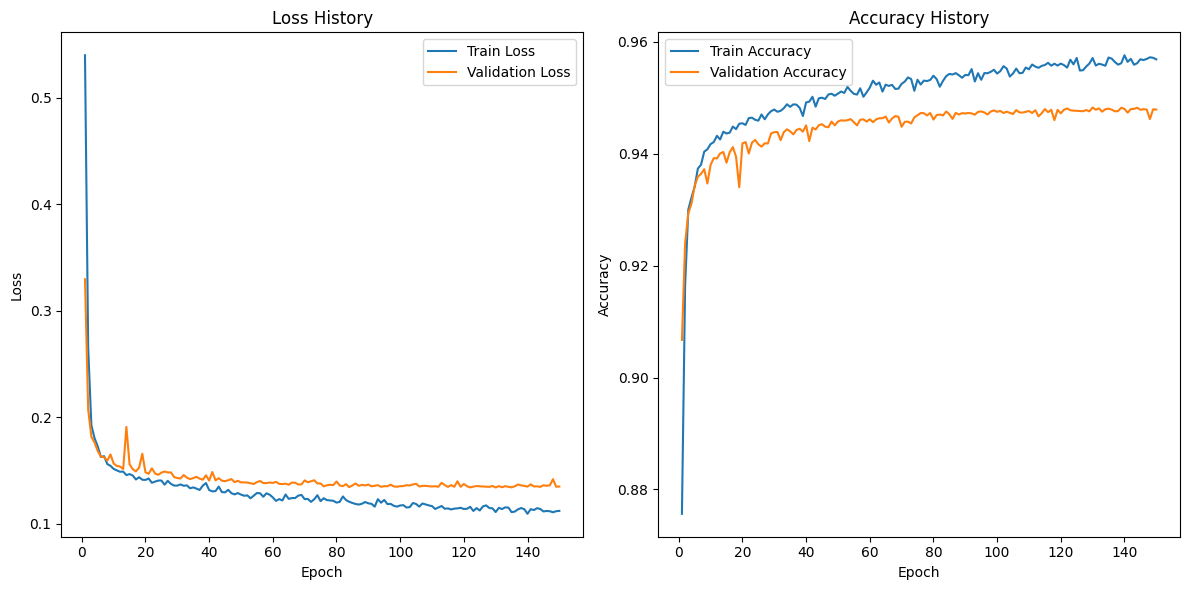

In [56]:
plot_loss_accuracy_history(best_results['metrics'])
# render(ax_client.get_contour_plot(param_x="lr", param_y="momentum", metric_name="accuracy"))
# render(ax_client.get_optimization_trace())

# 7. Explain the model predictions with Captum

In [ ]:
def visualize_attributions(attributions_seq, attributions_pssm, amino_acids=None):
    """
    可视化氨基酸序列和PSSM特征的归因分数。
    
    参数:
    - attributions_seq: 氨基酸序列的归因分数，形状为(batch_size, seq_len)。
    - attributions_pssm: PSSM特征的归因分数，形状为(batch_size, seq_len, num_features)。
    - amino_acids: 可选，氨基酸序列的列表，用于x轴标签。
    """
    # 假设我们只可视化第一个样本
    sample_attributions_seq = attributions_seq[0]
    sample_attributions_pssm = attributions_pssm[0]

    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    # 绘制氨基酸序列的归因分数条形图
    ax[0].bar(range(len(sample_attributions_seq)), sample_attributions_seq)
    ax[0].set_title('氨基酸序列的归因分数')
    ax[0].set_xlabel('氨基酸位置')
    ax[0].set_ylabel('归因分数')
    if amino_acids:
        ax[0].set_xticks(range(len(amino_acids)))
        ax[0].set_xticklabels(amino_acids, rotation=45, ha="right")

    # 绘制PSSM特征的归因分数热图
    cax = ax[1].matshow(sample_attributions_pssm, aspect='auto', cmap='viridis')
    fig.colorbar(cax, ax=ax[1])
    ax[1].set_title('PSSM特征的归因分数')
    
    ax[1].set_xlabel('特征')
    ax[1].set_ylabel('氨基酸位置')

    plt.tight_layout()
    plt.show()

In [ ]:
def attributions(model, dataloader_test):
    # integrated_gradients = IntegratedGradients(model)
    # 
    # sample = next(iter(dataloader_test))
    # sequences = sample['sequence'].to(device)
    # pssms = sample['pssm'].to(device)
    # 
    # attributions = integrated_gradients.attribute((sequences, pssms), target=0)
    # attributions = attributions.cpu().detach().numpy()
    # 
    # 
    # # attributions_seq = integrated_gradients.attribute(sequences, target=0)  # target是所求梯度的类索引
    # # attributions_pssm = integrated_gradients.attribute(pssms, target=0)
    # # 
    # # attributions_seq = attributions_seq.cpu().detach().numpy()
    # # attributions_pssm = attributions_pssm.cpu().detach().numpy()
    # 
    # return attributions
    
    # 归因计算逻辑
    # 注意：这里假设你想要对测试集中的第一个样本进行归因分析
    sample = next(iter(dataloader_test))
    sequences = sample['sequence'].to(device)
    pssms = sample['pssm'].to(device)

    # 确保使用模型的评估模式
    model.eval()

    # 初始化IntegratedGradients实例
    integrated_gradients = IntegratedGradients(model)

    # 计算归因
    # 重要：确保传递一个包含所有输入的元组，并且每个输入都是适当的数据类型
    attributions_seq, attributions_pssm = integrated_gradients.attribute(inputs=(sequences, pssms), target=0, additional_forward_args=None)
    attributions_seq = attributions_seq.cpu().detach().numpy()
    attributions_pssm = attributions_pssm.cpu().detach().numpy()

    # 这里，你可以根据需要进一步处理或保存归因结果
    ...

    return attributions_seq, attributions_pssm

In [ ]:
attributions_seq, attributions_pssm = attributions(test_model, dataloader_test)

In [ ]:
visualize_attributions(attributions_seq, attributions_pssm)